# Remove domain information from CPC embedding

In [22]:
import numpy as np
import pandas as pd
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [2]:
from GreedyInfoMax.vision.models import FullModel, load_vision_model
from GreedyInfoMax.vision.data import get_dataloader

In [3]:
# Read trained models
folder = 'E:\OneDrive - Sectra\Research\2020\project_dataembedding\greedyinfomax\experiments\20200207_163138'
model_num = 16

In [4]:
class Opt(object):
    pass
opt = Opt()
opt.negative_samples = 12
opt.model_splits = 3
opt.loss = 0
opt.resnet = 50
opt.grayscale = False
opt.prediction_step = 5
opt.train_module = 3
opt.weight_init = False
opt.learning_rate = 2e-4
opt.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt.batch_size = 5
opt.model_type = 0
opt.model_path = folder
opt.model_num = model_num
opt.experiment = 'vision'
opt.data_input_dir = 'E:/data/camelyon_tumor_20x'
opt.batch_size_multiGPU = 1
opt.validate = False

In [5]:
model, optimizer = load_vision_model.load_model_and_optimizer(opt, reload_model=True, calc_loss=False)

Contrasting against  12  negative samples
ModuleList(
  (0): ModuleList(
    (0): ResNet_Encoder(
      (model): Sequential(
        (Conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (layer 0): Sequential(
          (0): PreActBottleneckNoBN(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
            (shortcut): Sequential(
              (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
            )
          )
          (1): PreActBottleneckNoBN(
            (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
          )
          (2): PreActBottleneckNoBN(
            (conv1): Conv2d(256, 64, kernel_si

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\OneDrive - Sectra\\Research\x820\\project_dataembedding\\greedyinfomax\\experiments\x8200207_163138\\model_0_16.ckpt'

In [6]:
out_array = np.load('outputs.npy')
labels_array = np.load('labels.npy')
patch_ids = np.load('patch_ids.npy')

In [13]:
# Read dataset
df = pd.read_csv('E:/data/camelyon_tumor_20x/camelyon17_patches.csv')
df_slides = pd.read_csv('E:/data/tumor_data/slide_mapping_to_center.csv')

e:\.venvs\greedy_infomax-eqyl1qxu\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
# Add center to dataframe
def get_center(slide_id):
    center = df_slides[df_slides.slide_id == slide_id].center
    return int(center)

df['center'] = df.slide_id.map(get_center)

In [17]:
centers = [list(df[df.patch_id == patch_id].center)[0] for patch_id in patch_ids]

In [53]:
out_array.shape

(5000, 1024)

In [273]:
# Out_array only from center 0, 1, 2

df_centers = pd.DataFrame({'center': centers})
indicies_0 = df_centers[df_centers.center < 1].index
indicies_1234 = df_centers[df_centers.center >= 1].index
indicies_012 = df_centers[df_centers.center < 3].index
indicies_34 = df_centers[df_centers.center >= 3].index
# Filter 
out_array_012 = out_array[indicies_012, :]
labels_array_012 = labels_array[indicies_012]
centers_012 = np.asarray(centers)[indicies_012]

out_array_34 = out_array[indicies_34, :]
labels_array_34 = labels_array[indicies_34]
centers_34 = np.asarray(centers)[indicies_34]

out_array_0 = out_array[indicies_0, :]
labels_array_0 = labels_array[indicies_0]
centers_0 = np.asarray(centers)[indicies_0]

out_array_1234 = out_array[indicies_1234, :]
labels_array_1234 = labels_array[indicies_1234]
centers_1234 = np.asarray(centers)[indicies_1234]

In [569]:
# Dataloader

class ImagePatchesDataset(Dataset):
    def __init__(self, embedding, labels, image_dir, transform=None):
        self.embedding = embedding
        self.image_dir = image_dir
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.embedding)

    def __getitem__(self, index):
        coord = self.embedding[index]
        coord = np.expand_dims(coord, 0)
        
        if self.transform is not None:
            coord = self.transform(coord)
        else:
            coord = torch.tensor(coord)

        label = float(self.labels[index])

        return coord, label

training_data = ImagePatchesDataset(out_array[:4000], centers[:4000],  f'{opt.data_input_dir}/camelyon17_imagedata')
test_data = ImagePatchesDataset(out_array[4000:], centers[4000:],  f'{opt.data_input_dir}/camelyon17_imagedata')

In [571]:
train_loader = DataLoader(training_data, batch_size=24, shuffle=False)
test_loader = DataLoader(test_data, batch_size=24, shuffle=False)

In [572]:
use_gpu = torch.cuda.is_available()
print("GPU available: ", use_gpu)
device = torch.device('cuda:0')

GPU available:  True


In [573]:
# Small linear model

model = nn.Sequential(
    nn.Linear(in_features=1024, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=5)
#     nn.Sigmoid()
)

model.to(device)

Sequential(
  (0): Linear(in_features=1024, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=5, bias=True)
)

In [574]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [575]:
n_epochs = 20
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
    model.train()
    running_loss = 0
    for idx, batch in enumerate(train_loader):
        
        inputs = batch[0].to(device)
        labels = batch[1].to(device).long()
            
        optimizer.zero_grad()
        
        output = model(inputs)
#         output = output.squeeze()
        output = output[:, 0, :]
        
        loss = -criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        print('\r Train Epoch: {}, [{}/{} ({:.0f}%)] \t Loss: {:.6f}'.format(
              epoch, 
              idx*len(inputs), 
              len(train_loader.dataset),
              100.*idx/len(train_loader), 
              loss.item()/len(labels)), end="")
        
    train_losses.append(running_loss/len(train_loader))


In [576]:
try:
    for epoch in range(n_epochs):
        train(epoch)
except KeyboardInterrupt:
    print('\nKeybord interruption')

 Train Epoch: 19, [2656/4000 (99%)] 	 Loss: -39488152.000000

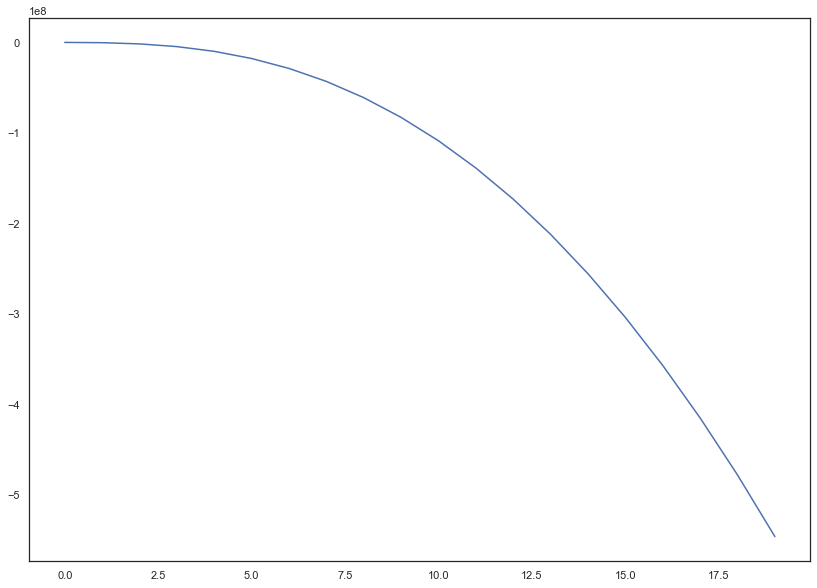

In [577]:
plt.plot(train_losses)

In [578]:
def test(data_loader):
    model.eval()
    outputs = []
    correct = 0
    df = pd.DataFrame()
    
    with torch.no_grad():
        for batch in data_loader:
            inputs = batch[0].to(device)
            labels = batch[1].to(device)
            
            output = model(inputs)
            output = output.squeeze()
            
#             test_loss += criterion(output, labels).item()
            pred = output.data.max(1, keepdim=True)[1]
            print(pred, labels)
            correct += pred.eq(labels.data.view_as(pred)).sum()
            
            data = {'label': labels.detach().cpu().numpy(), 'prediction': pred.detach().cpu().numpy().squeeze()}
            df = pd.concat([df, pd.DataFrame(data)])
        
        outputs.extend(output.detach().cpu().numpy())
    print(f'\nAccuracy: {correct} / {len(data_loader)*12}')
    print(str(correct.item()/(len(data_loader)*12)*100) + ' %')
    return outputs

In [579]:
test_results = test(train_loader)
# test_results = test(test_loader)

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], device='cuda:0') tensor([0., 4., 1., 4., 3., 0., 3., 4., 2., 3., 4., 3., 3., 0., 0., 0., 0., 2.,
        2., 4., 4., 3., 0., 3.], device='cuda:0', dtype=torch.float64)
tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], device='cuda:0') tensor([4., 0., 3., 4., 0., 0., 3., 4., 4., 2., 3., 0., 3., 4., 0., 0., 2., 1.,
        4., 0., 4., 4., 2., 0.], device='cuda:0', dtype=torch.float64)
tensor([[1],
        [1],
        [1],

In [564]:
test_results = np.stack(np.stack(test_results, axis=1), axis=1)
test_results

array([[-61647164.  , -49443484.  , -45606896.  ,  62370476.  ,
           695874.6 ],
       [-59586964.  , -47791076.  , -44082052.  ,  60286028.  ,
           672623.44],
       [-54062120.  , -43359990.  , -39995910.  ,  54696468.  ,
           610251.4 ]], dtype=float32)

In [544]:
# UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(test_results)
embedding.shape

e:\.venvs\greedy_infomax-eqyl1qxu\lib\site-packages\umap\umap_.py:1383: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "
e:\.venvs\greedy_infomax-eqyl1qxu\lib\site-packages\scipy\sparse\linalg\eigen\arpack\arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


TypeError: Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.

In [285]:
# df_012 = pd.DataFrame({'x': embedding[:, 0], 'y': embedding[:, 1], 'label': labels_array_012, 'center': centers_012})
df_0 = pd.DataFrame({'x': embedding[:, 0], 'y': embedding[:, 1], 'label': labels_array_0, 'center': centers_0})

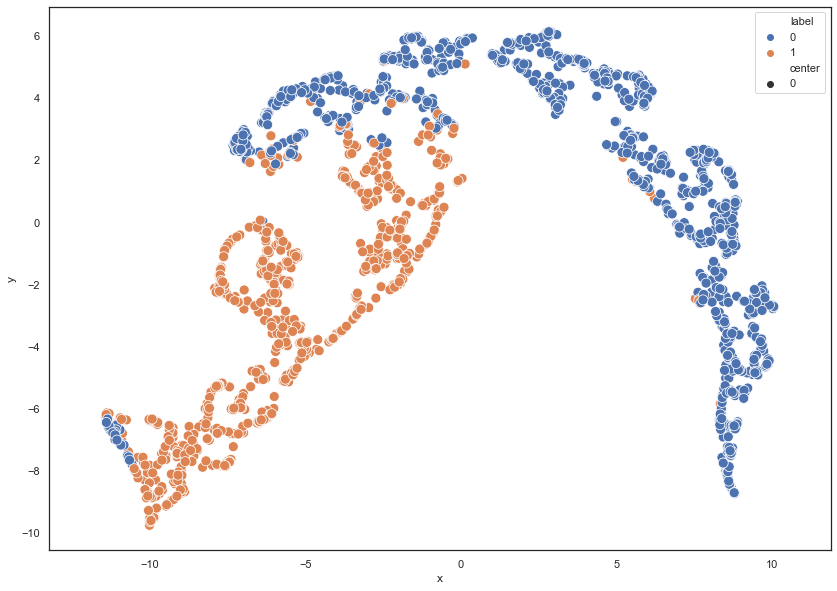

In [288]:
sns.scatterplot(x='x', y='y', style='center', hue='label', data=df_0, palette=sns.color_palette("deep", 2), s=100)
g = plt.gca().set_aspect('equal', 'datalim')

In [289]:
# test_34_results = test(test_loader)
test_1234_results = test(test_loader)

 Train Epoch: 19, [2805/1929 (158%)] 	 Loss: 0.129621

In [290]:
test_1234_results = np.stack(np.stack(test_1234_results, axis=1), axis=1)
test_1234_results.shape

(3071, 128)

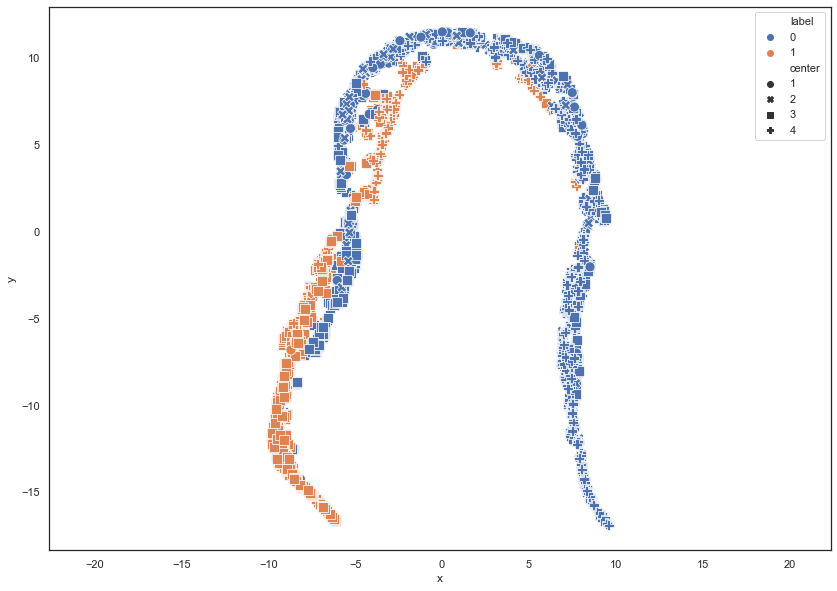

In [292]:
reducer = umap.UMAP()
embedding2 = reducer.fit_transform(test_1234_results)
embedding2.shape


df_1234 = pd.DataFrame({'x': embedding2[:, 0], 'y': embedding2[:, 1], 'label': labels_array_1234, 'center': centers_1234})
sns.scatterplot(x='x', y='y', style='center', hue='label', data=df_1234, palette=sns.color_palette("deep", 2), s=100)
g = plt.gca().set_aspect('equal', 'datalim')

In [248]:
test_results_01234 = np.append(test_results, test_34_results, axis=0)
reducer = umap.UMAP()
tot_emb = reducer.fit_transform(test_results_01234)
tot_emb.shape

labels_array_01234 = np.append(labels_array_012, labels_array_34, axis=0)
centers_01234 = np.append(centers_012, centers_34, axis=0)
df_01234 = pd.DataFrame({'x': tot_emb[:,0], 'y': tot_emb[:, 1], 'label': labels_array_01234, 'center': centers_01234})

e:\.venvs\greedy_infomax-eqyl1qxu\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\.venvs\greedy_infomax-eqyl1qxu\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


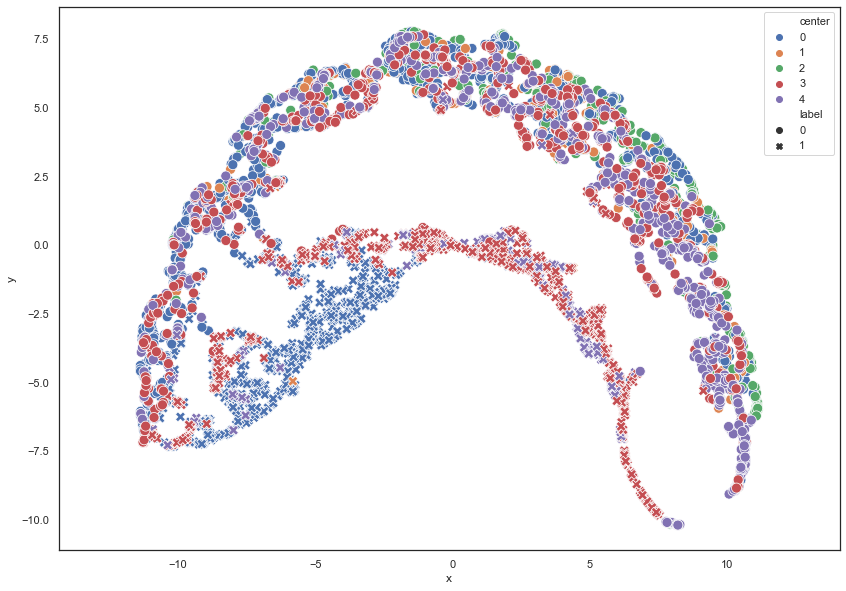

In [249]:
sns.scatterplot(x='x', y='y', style='label', hue='center', data=df_01234, palette=sns.color_palette("deep", 5), s=100)
g = plt.gca().set_aspect('equal', 'datalim')

# Test on colon data

In [580]:
outputs_colon = np.load('outputs_colon.npy')
patch_ids_colon = np.load('patch_ids_colon.npy')
labels_colon = np.load('labels_colon.npy')

In [584]:
df_colon = pd.read_csv('E:/data/colon/exp_1911apka/colon_patches.csv')

e:\.venvs\greedy_infomax-eqyl1qxu\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [585]:
df_colon.head(1)

,Unnamed: 0,seriesInstanceUid,label,request_id,slide_id,block,stain,resolution,scanPower,width,height,source,is_primtumor,annot_id,srctype,is_validation,position_x,position_y,filename,center
0,0,10104,roi_lgl_norm,AIDA-CR1-A-000001,10104.0,K,HE;11,0.4944,20.0,59759.0,29349.0,lkpg,False,10345,Area,False,0.124381,0.043848,roi_lgl_norm/0.jpg,1


In [586]:
request_ids = [list(df_colon[df_colon.filename == f'{patch_id}.jpg'].request_id)[0] for patch_id in patch_ids_colon]

In [592]:
len(labels_colon)

1000

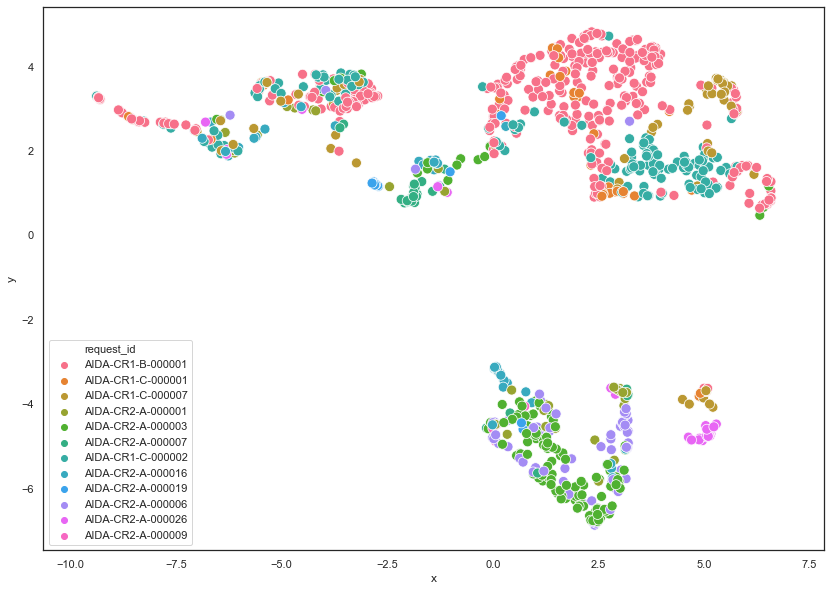

In [595]:
reducer = umap.UMAP()
embedding2 = reducer.fit_transform(outputs_colon)
embedding2.shape


df_c = pd.DataFrame({'x': embedding2[:, 0], 'y': embedding2[:, 1], 'label': labels_colon, 'request_id': request_ids[:1000]})
sns.scatterplot(x='x', y='y', hue='request_id', data=df_c, s=100)
g = plt.gca().set_aspect('equal', 'datalim')

In [259]:
centers_colon = [int(list(df_colon[df_colon.filename == f'{id_}.jpg'].center)[0]) for id_ in patch_ids_colon]

In [261]:
test_data_colon = ImagePatchesDataset(outputs_colon, labels_colon, image_dir='E:/data/colon/exp_1911apka/colon_imagedata')

In [262]:
test_colon_loader = DataLoader(test_data_colon, batch_size=12, shuffle=False)

In [263]:
colon_results = test(test_colon_loader)

 Train Epoch: 19, [332/2585 (38%)] 	 Loss: 0.936109

In [265]:
colon_results = np.stack(np.stack(colon_results, axis=1), axis=1)
colon_results.shape

(1000, 128)

In [267]:
reducer = umap.UMAP()
embedding3 = reducer.fit_transform(colon_results)
embedding3.shape



(1000, 2)

In [270]:
np.asarray(centers_colon).shape

(1001,)

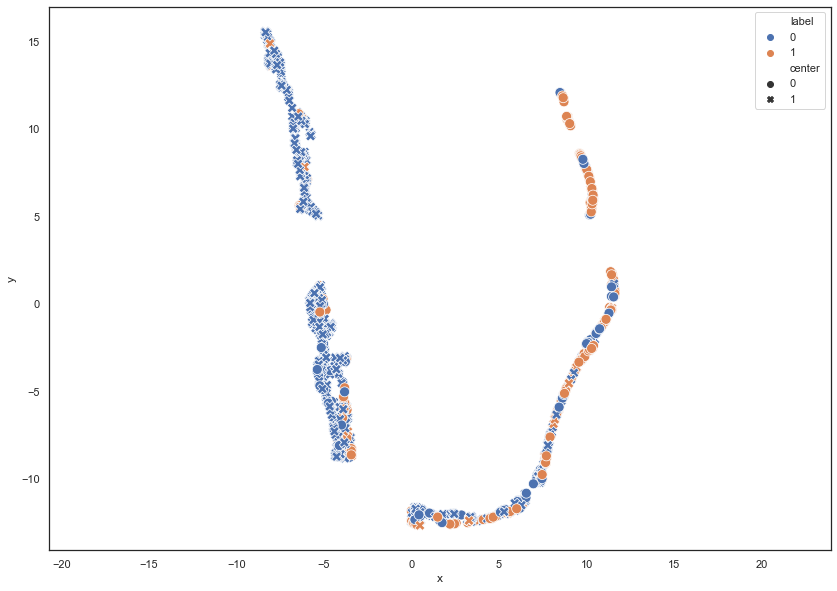

In [272]:

df_colon = pd.DataFrame({'x': embedding3[:, 0], 'y': embedding3[:, 1], 'label': labels_colon, 'center': centers_colon[:1000]})
sns.scatterplot(x='x', y='y', style='center', hue='label', data=df_colon, palette=sns.color_palette("deep", 2), s=100)
g = plt.gca().set_aspect('equal', 'datalim')